In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm 
from glob import glob
from skimage.io import imread
from skimage.measure import label, regionprops_table
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, ElasticNet, SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
import seaborn as sns

In [3]:
warnings.filterwarnings('ignore')

In [4]:
def print_evaluate(true, predicted):
    
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def run_all_regressions(X_train, X_test, Y_train, Y_test, regs):

    for name, model in regs.items():

        model.fit(X_train, Y_train)
        
        print(f'\n-----{name}------')
        print('[Train] -------------')
        print_evaluate(Y_train, model.predict(X_train))

        print("\n")
        
        print('[Test] --------------')
        print_evaluate(Y_test, model.predict(X_test))

def extract_props_from_image(mask):
    
    label_image = label(mask)

    feature_names = ['bbox_area',
                     'solidity',
                     'equivalent_diameter', 
                     'orientation',
                     'convex_area', 
                     'area',
                     'extent',
                     'eccentricity',
                     'major_axis_length',
                     'feret_diameter_max',
                     'perimeter',
                     'minor_axis_length']
    
    return pd.DataFrame(regionprops_table(label_image, properties=feature_names))

def labeling_dataset(pd_features, weights_filepath):

    pd_dataset = pd_features.copy()
    
    broilers_weights = pd.read_csv(weights_filepath)

    pd_dataset['target'] = -1

    for anilha, peso in zip(broilers_weights.id,  broilers_weights.weight):

        try: 
            index, *_ = pd_dataset[pd_dataset.label == anilha].index
            pd_dataset.target.iloc[index] = peso
        except:
            continue

    pd_dataset.label.apply(lambda value: value in broilers_weights.id.to_list())

    pd_dataset.drop(pd_dataset[pd_dataset.target < 1].index, inplace=True)

    return pd_dataset

def build_features_dataset(origin_images):
    system_bar = define_barra_path()
    out = pd.DataFrame()

    for path_mask in tqdm(glob(origin_images + f"{system_bar}*")):
        try:
            mask = imread(path_mask)

            props = extract_props_from_image(mask)
            label_name = path_mask.split(system_bar)[-1].split('.')[0]
            props['label'] = int(label_name)

            out = pd.concat([out, props], ignore_index=True)
        
        except Exception as e:
            print("Erro na imagem:", e, end="\n")
            break
            
    return out

def define_barra_path():
    import os
    barra = "/"
    
    if os.name == 'nt':
        barra = "\\"
        
    return barra

In [5]:
features = build_features_dataset("selecionadas")

100%|██████████████████████████████████████████████████████| 154/154 [00:02<00:00, 63.41it/s]


In [6]:
features_labeling = labeling_dataset(features, "annotations.csv")

In [7]:
features_labeling.head()

,bbox_area,solidity,equivalent_diameter,orientation,convex_area,area,extent,eccentricity,major_axis_length,feret_diameter_max,perimeter,minor_axis_length,label,target
0,52360,0.825398,191.189524,-1.458943,34782,28709,0.548300,0.971375,416.151878,445.223539,1052.766594,98.856579,8,2260
1,39816,0.882290,158.186525,-1.136002,22275,19653,0.493596,0.922756,259.053809,282.193196,732.465079,99.835596,141,1410
2,49280,0.744458,164.519076,1.428224,28555,21258,0.431372,0.960301,335.429795,390.616180,1016.240728,93.573909,51,1700
3,19412,0.788183,112.260968,1.509138,12558,9898,0.509891,0.929703,199.915772,213.412746,554.386868,73.631157,79,1458
4,45540,0.792081,176.066928,1.487811,30738,24347,0.534629,0.967238,376.026862,420.918044,1001.843758,95.462442,97,1447


In [8]:
# features_labeling.target = features_labeling.target / 1000

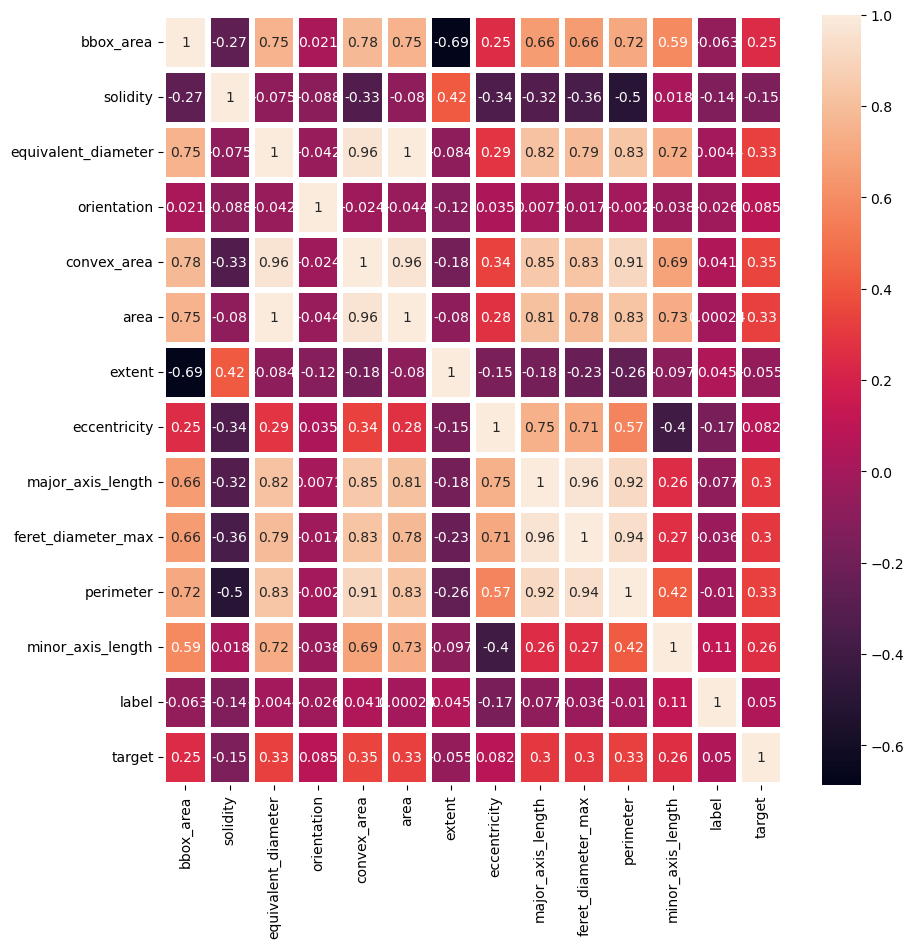

In [9]:
_, ax = plt.subplots(figsize=(10, 10))
corrmat = features_labeling.corr()
sns.heatmap(corrmat, linewidths=3, annot=True);

In [10]:
corrmat[corrmat.target > 0].target

bbox_area              0.246509
equivalent_diameter    0.331548
orientation            0.085262
convex_area            0.347012
area                   0.330475
eccentricity           0.081811
major_axis_length      0.300184
feret_diameter_max     0.300974
perimeter              0.331609
minor_axis_length      0.255709
label                  0.049800
target                 1.000000
Name: target, dtype: float64

In [11]:
features_names = list(dict(corrmat[corrmat.target >= 0].target).keys())

In [12]:
y = features_labeling.target
X = features_labeling[features_names].drop(labels=['target', "label"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X.values, 
                                                    y.values, 
                                                    test_size=0.3,
                                                    random_state=0)

In [13]:
scaler = StandardScaler()

scaled_x_train, scaled_x_test = scaler.fit_transform(X_train), scaler.fit_transform(X_test)

In [14]:
scaler = StandardScaler()

scaled_x_train, scaled_x_test = scaler.fit_transform(X_train), scaler.fit_transform(X_test)

In [15]:
run_all_regressions(scaled_x_train, 
                    scaled_x_test,
                    y_train,
                    y_test,
                    regs = {
                        "Random Forest":RandomForestRegressor(),
                        "Lasso": Lasso(), 
                        "LinearRegression": LinearRegression(),
                        "Ridge": Ridge()
                    })


-----Random Forest------
[Train] -------------
MAE: 77.35065420560748
MSE: 10753.557869158876
RMSE: 103.69936291587753
R2 Square 0.8674994052482939


[Test] --------------
MAE: 206.32191489361705
MSE: 72704.29421489361
RMSE: 269.63733831740296
R2 Square -0.24235842588620926

-----Lasso------
[Train] -------------
MAE: 189.36387918382005
MSE: 64239.85491923989
RMSE: 253.45582439399553
R2 Square 0.20846485534109338


[Test] --------------
MAE: 211.83632593754024
MSE: 69011.33119653627
RMSE: 262.70007840984033
R2 Square -0.1792537114826609

-----LinearRegression------
[Train] -------------
MAE: 189.5679404649587
MSE: 63740.63421836597
RMSE: 252.469075766451
R2 Square 0.21461603252198413


[Test] --------------
MAE: 215.0530391460345
MSE: 74536.83091380153
RMSE: 273.0143419562451
R2 Square -0.2736724965778903

-----Ridge------
[Train] -------------
MAE: 189.34726003932994
MSE: 64117.81469375247
RMSE: 253.21495748425383
R2 Square 0.20996858114584238


[Test] --------------
MAE: 210.8178916